<font size="5">Importing Libraries</font>

In [5]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

<font size="5">Constants for preprocessing</font>

In [6]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

DATA_DIR = 'brain-tumor-dataset'
IMAGES_DIR = os.path.join(DATA_DIR, 'images')
MASKS_DIR = os.path.join(DATA_DIR, 'masks')

<font size="5">Load Dataset</font>

The dataset consists of 3064 brain mri images consisting of original images and masks

In [ ]:
print("Loading and preprocessing data...")
image_files = sorted(os.listdir(IMAGES_DIR))
mask_files = sorted(os.listdir(MASKS_DIR))

print(f"Total number of images: {len(image_files)}")
print(f"Total number of masks: {len(mask_files)}")

X = np.zeros((len(image_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
y = np.zeros((len(mask_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.int32)

for idx, (img_file, mask_file) in enumerate(zip(image_files, mask_files)):
    img_path = os.path.join(IMAGES_DIR, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    X[idx] = img / 255.0
    
    mask_path = os.path.join(MASKS_DIR, mask_file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    mask = np.expand_dims(mask > 0, axis=-1)
    y[idx] = mask

Loading and preprocessing data...
Total number of images: 3064
Total number of masks: 3064
Processed 100 images
Processed 200 images
Processed 300 images
Processed 400 images
Processed 500 images
Processed 600 images
Processed 700 images
Processed 800 images
Processed 900 images
Processed 1000 images
Processed 1100 images
Processed 1200 images
Processed 1300 images
Processed 1400 images
Processed 1500 images
Processed 1600 images
Processed 1700 images
Processed 1800 images
Processed 1900 images
Processed 2000 images
Processed 2100 images
Processed 2200 images
Processed 2300 images
Processed 2400 images
Processed 2500 images
Processed 2600 images
Processed 2700 images
Processed 2800 images
Processed 2900 images
Processed 3000 images


<font size="5">Visualizing the Sample Images</font>

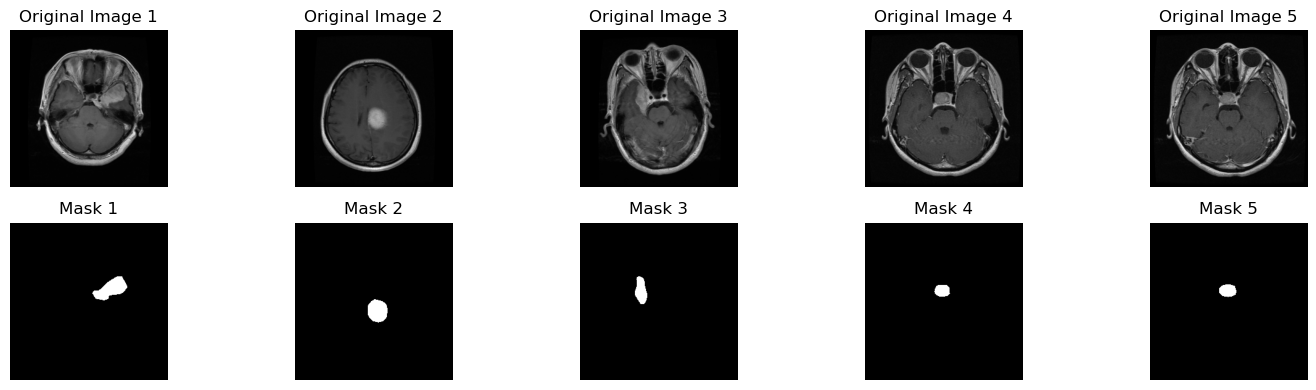

In [8]:
plt.figure(figsize=(15, 4))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i])
    plt.title(f'Original Image {i+1}')
    plt.axis('off')
    
    plt.subplot(2, 5, i + 6)
    plt.imshow(y[i].squeeze(), cmap='gray')
    plt.title(f'Mask {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

<font size="5">Analyzing Tumor Sizes</font>

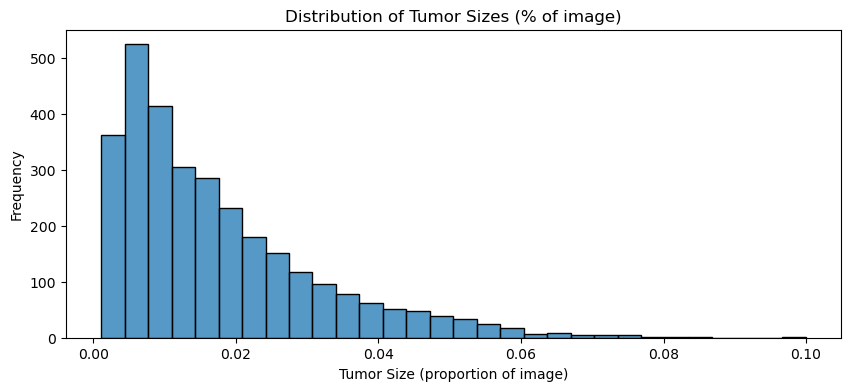

Average tumor size: 1.75% of image
Median tumor size: 1.34% of image
Max tumor size: 9.99% of image
Min tumor size: 0.11% of image


In [9]:
tumor_sizes = [np.sum(mask) / (IMG_WIDTH * IMG_HEIGHT) for mask in y]

plt.figure(figsize=(10, 4))
sns.histplot(tumor_sizes, bins=30)
plt.title('Distribution of Tumor Sizes (% of image)')
plt.xlabel('Tumor Size (proportion of image)')
plt.ylabel('Frequency')
plt.show()

print(f"Average tumor size: {np.mean(tumor_sizes):.2%} of image")
print(f"Median tumor size: {np.median(tumor_sizes):.2%} of image")
print(f"Max tumor size: {np.max(tumor_sizes):.2%} of image")
print(f"Min tumor size: {np.min(tumor_sizes):.2%} of image")

<font size="5">Splitting Dataset into Test and Train</font>

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 2451
Testing set size: 613


<font size="5">Creating the unet model</font>

In [ ]:
input_layer = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Encoder
c1 = Conv2D(16, 3, activation='relu', padding='same')(input_layer)
p1 = MaxPooling2D()(c1)

c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
p2 = MaxPooling2D()(c2)

c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)
p3 = MaxPooling2D()(c3)

# Bridge
c4 = Conv2D(128, 3, activation='relu', padding='same')(p3)

# Decoder
u5 = Conv2DTranspose(64, 2, strides=2, padding='same')(c4)
u5 = concatenate([u5, c3])
c5 = Conv2D(64, 3, activation='relu', padding='same')(u5)

u6 = Conv2DTranspose(32, 2, strides=2, padding='same')(c5)
u6 = concatenate([u6, c2])
c6 = Conv2D(32, 3, activation='relu', padding='same')(u6)

u7 = Conv2DTranspose(16, 2, strides=2, padding='same')(c6)
u7 = concatenate([u7, c1])
c7 = Conv2D(16, 3, activation='relu', padding='same')(u7)

outputs = Conv2D(1, 1, activation='sigmoid')(c7)

model = Model(inputs=[input_layer], outputs=[outputs])

<font size="5">Compile and Train Model</font>

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=16,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
    ]
)

Epoch 1/10


c:\Users\Aashish\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


154/154 ━━━━━━━━━━━━━━━━━━━━ 120s 701ms/step - accuracy: 0.9695 - auc: 0.5792 - loss: 0.2143 - precision: 0.0280 - recall: 0.0221 - val_accuracy: 0.9819 - val_auc: 0.8466 - val_loss: 0.0735 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 106s 686ms/step - accuracy: 0.9828 - auc: 0.8427 - loss: 0.0710 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9819 - val_auc: 0.8706 - val_loss: 0.0711 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 108s 702ms/step - accuracy: 0.9824 - auc: 0.8493 - loss: 0.0714 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9819 - val_auc: 0.8571 - val_loss: 0.0771 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 102s 662ms/step - accuracy: 0.9824 - auc: 0.8606 - loss: 0.0701 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accura

<font size="5">Plotting training history</font>

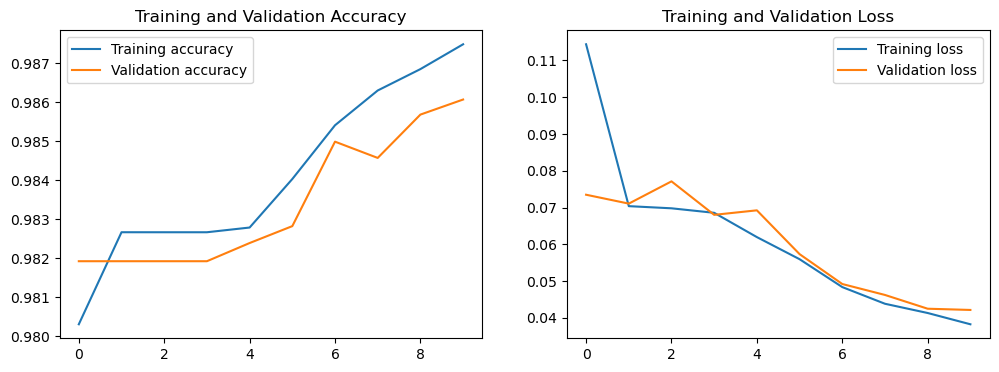

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

<font size="5">Calculating Metrics</font>

In [ ]:
test_predictions = model.predict(X_test)

# Convert predictions to binary using 0.5 threshold
test_predictions_binary = (test_predictions > 0.5).astype(np.float32)

# Calculating Dice Coefficient
intersection = np.sum(y_test * test_predictions_binary)
dice_score = (2. * intersection) / (np.sum(y_test) + np.sum(test_predictions_binary))

# Calculate IoU (Intersection over Union)
union = np.sum(y_test) + np.sum(test_predictions_binary) - intersection
iou = intersection / union

# Calculating Precision and Recall
true_positives = intersection
false_positives = np.sum(test_predictions_binary) - intersection
false_negatives = np.sum(y_test) - intersection

precision = true_positives / (true_positives + false_positives + 1e-7)
recall = true_positives / (true_positives + false_negatives + 1e-7)

print("\nTest Set Metrics:")
print(f"Dice Score: {dice_score:.4f}")
print(f"IoU: {iou:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

<font size="5">Visualizing Predictions</font>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


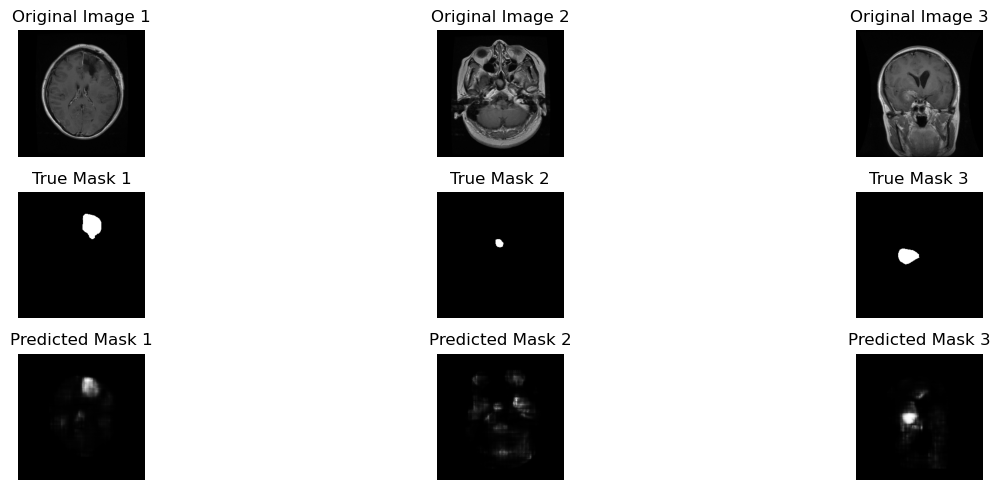

In [14]:
predictions = model.predict(X_test[:3])

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[i])
    plt.title(f'Original Image {i+1}')
    plt.axis('off')
    
    plt.subplot(3, 3, i + 4)
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    plt.title(f'True Mask {i+1}')
    plt.axis('off')
    
    plt.subplot(3, 3, i + 7)
    plt.imshow(predictions[i].squeeze(), cmap='gray')
    plt.title(f'Predicted Mask {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()